<a href="https://colab.research.google.com/github/bori00/BreastCancerSegmentation/blob/main/Breast_Cancer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

Dataset: https://github.com/PathologyDataScience/BCSS
Paper: https://academic.oup.com/bioinformatics/article/35/18/3461/5307750

# Setup: Importing the libraries and the dataset

In [ ]:
import tensorflow as tf

import urllib
from urllib import request

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import numpy as np

In [ ]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading Images and Masks

In [ ]:
TEST_RATIO = 0.2
SEED = 123
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 32

In [ ]:
!unzip gdrive/My\ Drive/PRS_Project/masks-20221122T203004Z-001.zip
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip

In [ ]:
def toInt(image):
    return tf.cast(image, tf.int32)

In [ ]:
train_images_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/rgbs_colorNormalized',
  labels=None,
  validation_split=TEST_RATIO,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE).map(toInt)

test_images_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/rgbs_colorNormalized',
  labels=None,
  validation_split=TEST_RATIO,
  subset="validation",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE).map(toInt)

Found 151 files belonging to 1 classes.
Using 121 files for training.
Found 151 files belonging to 1 classes.
Using 30 files for validation.


In [ ]:
train_masks_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/masks/',
  labels=None,
  validation_split=TEST_RATIO,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE).map(toInt)

test_images_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/masks/',
  labels=None,
  validation_split=TEST_RATIO,
  subset="validation",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE).map(toInt)

Found 151 files belonging to 1 classes.
Using 121 files for training.
Found 151 files belonging to 1 classes.
Using 30 files for validation.


## Loading the Class Definitions

In [ ]:
classes_df = pd.read_csv("gtruth_codes.csv")
classes_df

,label,GT_code
0,outside_roi,0
1,tumor,1
2,stroma,2
3,lymphocytic_infiltrate,3
4,necrosis_or_debris,4
5,glandular_secretions,5
6,blood,6
7,exclude,7
8,metaplasia_NOS,8
9,fat,9


**Important**: The "outside_roi" class is "don't case", not "others", and should be assigned weight 0 in the model.

# Exploratory Data Analysis

In [ ]:
def plot_image_and_mask(image_name):
  plt.figure(figsize=(20, 8))
  plt.suptitle("Image: " + image_name)

  plt.subplot(1, 2, 1)
  mask = mpimg.imread('/content/masks/' + image_name)
  plt.imshow(mask)
  plt.title("Mask")
  
  plt.subplot(1, 2, 2)
  image = mpimg.imread('/content/rgbs_colorNormalized/' + image_name)
  plt.imshow(image)
  plt.title("Image")

  plt.show()

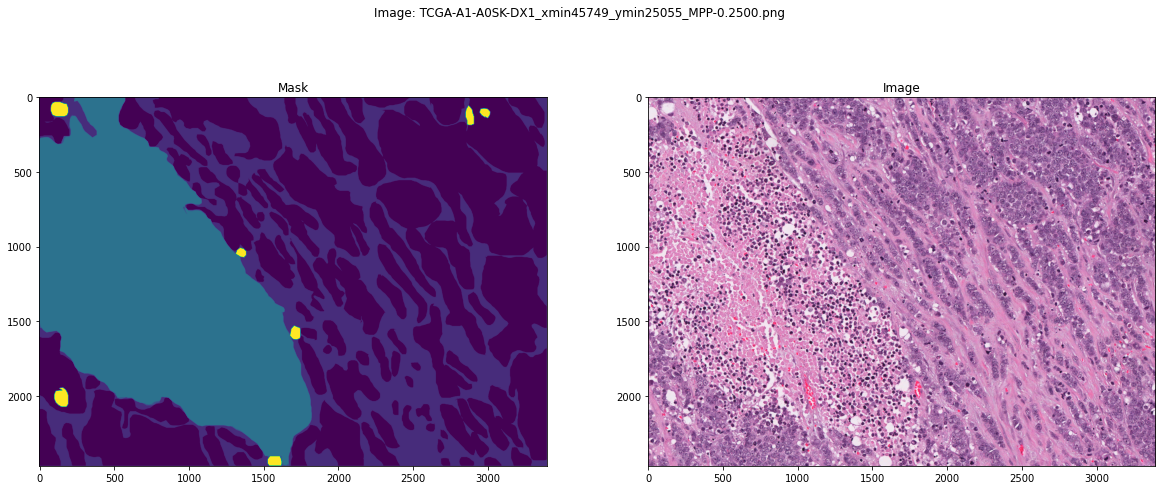

In [ ]:
plot_image_and_mask('TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500.png')

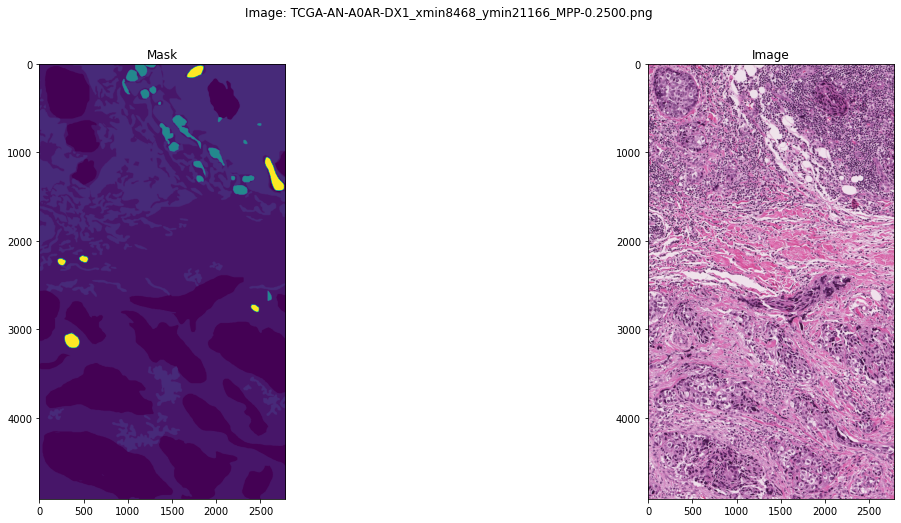

In [ ]:
plot_image_and_mask('TCGA-AN-A0AR-DX1_xmin8468_ymin21166_MPP-0.2500.png')

In [ ]:
def visualize_batch_per_categories(image_batch, mask_batch):
  # create Ax8 subplots
  plt.figure(figsize=(20 * BATCH_SIZE / 4, 40 * 8))
  plt.suptitle("One Batch of Data")

  # add subfigure per subplot
  index = 0
  for images in image_batch:
    for image in images:
      plt.subplot(BATCH_SIZE / 4, 8, 2 * index + 1)
      plt.imshow(image)
      index = index + 1

  index = 0
  for masks in mask_batch:
    for mask in masks:
      plt.subplot(BATCH_SIZE / 4, 8, 2 * index + 2)
      plt.imshow(mask)
      index = index + 1

  plt.show()

In [ ]:
visualize_batch_per_categories(train_images_ds.take(1), train_masks_ds.take(1))